<a href="https://colab.research.google.com/github/YujiSue/Lecture/blob/master/TWMU_2020_s1_Lecture_02_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# そろそろ真面目に診断します  
NIHが公開している画像の中から、あらかじめ「健常者」のものと「心拡大」症状の患者さんのものとに分類した画像フォルダをダウンロードします。

In [0]:
#心臓の画像を読み込む
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R6QasEe5T1-xdBKXMN-KHeatEGHOTi23' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R6QasEe5T1-xdBKXMN-KHeatEGHOTi23" -O Data1.zip && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nEJpHZMyfiUp9Ro3qxmuC89PxBmhWQMA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nEJpHZMyfiUp9Ro3qxmuC89PxBmhWQMA" -O Data2.zip && rm -rf /tmp/cookies.txt
!unzip -q "Data1.zip"
!unzip -q "Data2.zip"
!mv "Normal/00000006_000.png" "normal.png"
!mv "Cardio/00000001_002.png" "cardiomegaly.png"

試しに見比べます

健常：


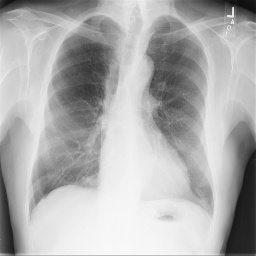



心拡大：


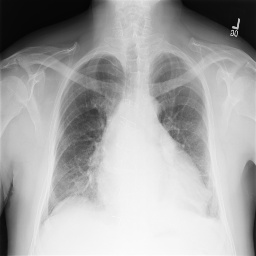

In [23]:
import cv2
from IPython.display import Image, display_jpeg, display_png, display_pdf

def showCVImage(mat):
  decoded_bytes = cv2.imencode('.jpg', mat)[1].tobytes()
  display(Image(data=decoded_bytes))

norm1 = cv2.imread('normal.png')
norm1_ = cv2.resize(norm1, (256, 256))
abnorm1 = cv2.imread('cardiomegaly.png')
abnorm1_ = cv2.resize(abnorm1, (256, 256))
print('健常：')
showCVImage(norm1_)
print('\n')
print('心拡大：')
showCVImage(abnorm1_)

# まずはAIの頭脳（ニューラルネット）の構築

In [0]:
from keras.initializers import TruncatedNormal, Constant
from keras.preprocessing import image
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization
from keras.callbacks import Callback, EarlyStopping
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib import ticker
import glob
import numpy as np
import datetime

# もともとkerasに用意されていた関数を利用して畳み込み関数を作成
def 畳み込み(フィルタ枚数, サイズ, ストライド,  **その他の引数):
    return Conv2D(フィルタ枚数, サイズ, strides=ストライド,
                padding='same', activation='relu',
                kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
                bias_initializer=Constant(value=1),
                **その他の引数
    )
# もともとkerasに用意されていた関数を利用してプーリング関数を作成
def プーリング(サイズ, ストライド):
    return MaxPooling2D(pool_size=サイズ, strides=ストライド)

# もともとkerasに用意されていた関数を利用して全結合関数を作成
def 全結合(ニューロン数, **その他の引数):
    return Dense(ニューロン数, 
        kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01),
        bias_initializer=Constant(value=1),
        **その他の引数
    )

class AIの頭脳:
  def __init__(self):
    self.脳の構造 = Sequential()
    # 畳み込み層（１層目）
    self.脳の構造.add(畳み込み(32, 11, (4, 4), input_shape=(224, 224, 1)))
    # プーリング層
    self.脳の構造.add(プーリング((3, 3), (2, 2)))
    self.脳の構造.add(BatchNormalization())

    # 畳み込み層（２層目）
    self.脳の構造.add(畳み込み(84, 5, (1, 1)))
    # プーリング層
    self.脳の構造.add(プーリング((3, 3), (2, 2)))
    self.脳の構造.add(BatchNormalization())

    # 畳み込み層（３層目）
    self.脳の構造.add(畳み込み(128, 3, (1, 1)))
    # 畳み込み層（４層目）
    self.脳の構造.add(畳み込み(128, 3, (1, 1)))
    # 畳み込み層（５層目）
    self.脳の構造.add(畳み込み(84, 3, (1, 1)))
    # プーリング層
    self.脳の構造.add(プーリング((3, 3), (2, 2)))
    self.脳の構造.add(BatchNormalization())

    # 全結合層
    # １次元のニューロン列へ
    self.脳の構造.add(Flatten())
    # 全結合x２
    self.脳の構造.add(全結合(4096))
    self.脳の構造.add(Dropout(0.5))
    self.脳の構造.add(全結合(4096))
    self.脳の構造.add(Dropout(0.5))

    # 出力層
    # 状態は健常か心拡大かの２通り
    self.脳の構造.add(全結合(2, activation='softmax'))
    
    # 脳の構造を最終確定
    self.脳の構造.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    # 学習過程を記録しておく
    # どんな風に賢くなったかが見れる
    self.学習の履歴 = None

  # 脳の構造をあとで確認したくなったとき用
  # 絵面を想像すると微妙だった...
  # 関数名はちゃんと考えてつけましょうという教訓
  def 頭の中身(self):
    self.脳の構造.summary()
    
  # 実際の学習を行う関数
  # 今回は教師あり(健常か心拡大か過去に医師が判定した結果がある)学習
  def 勉強(self, 画像, 教師):
    self.学習の履歴 = self.脳の構造.fit(学習用画像, 教師, batch_size=32, epochs=60)
  
  # 未知の患者のデータに対して、健常かそうでないか予測する関数
  def 予測(self, テスト画像):
    return self.脳の構造.predict(テスト画像, verbose=0)

  # 記録しておいた学習過程をグラフで表示
  def 進捗の確認(self):
    plt.plot(self.学習の履歴.history['accuracy'],"o-",label="accuracy")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


In [0]:
# 学習用のデータ作成
学習用画像 = []
診断結果 = []

# 各フォルダから画像を読み込む
files = glob.glob("Normal/*")
for file in files:
    img = image.load_img(file, color_mode = "grayscale", target_size=(224, 224))
    学習用画像.append(image.img_to_array(img))
    診断結果.append(0) # 健常 = 0

files = glob.glob("Cardio/*")
for file in files:
    img = image.load_img(file, color_mode = "grayscale", target_size=(224, 224))
    学習用画像.append(image.img_to_array(img))
    診断結果.append(1) # 心拡大 = 1

# 大規模計算用に形式変換
学習用画像 = np.array(学習用画像)
学習用画像 = 学習用画像.astype('float32')
学習用画像 = 学習用画像 / 255.0
診断結果 = np.array(診断結果)
診断結果 = to_categorical(診断結果, 2)

## 実際に学習させる

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 56, 56, 32)        3904      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 84)        67284     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 84)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 84)        336       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)      

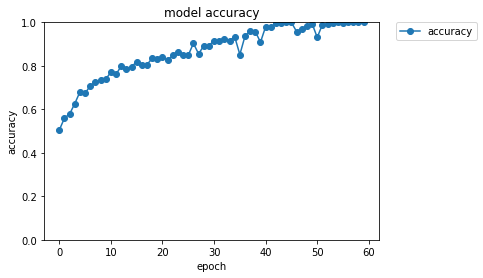

In [8]:
AI１号 = AIの頭脳()
AI１号.頭の中身()
AI１号.勉強(学習用画像, 診断結果)
AI１号.進捗の確認()

# 学習結果の保存
open('model.json',"w").write(AI１号.脳の構造.to_json())
AI１号.脳の構造.save_weights('weight.hdf5')
# 学習結果の呼び出し
# model_from_json(open('model.json',"w").read(AI１号.脳の構造.to_json()))
# AI１号.脳の構造.load_weights('weight.hdf5')

In [0]:
# テスト用コード
# 読み飛ばしていい
テスト画像 = []
img1 = image.load_img('normal.png', color_mode = "grayscale", target_size=(224, 224))
テスト画像.append(image.img_to_array(img1))
img2 = image.load_img('cardiomegaly.png', color_mode = "grayscale", target_size=(224, 224))
テスト画像.append(image.img_to_array(img2))
テスト画像 = np.array(テスト画像)
テスト画像 = テスト画像.astype('float32')
テスト画像 = テスト画像 / 255.0

予測結果 = AI１号.予測(テスト画像)
print(予測結果)
for i in range(0,2):
    print(i,'枚目の画像：')
    print('　正常な可能性　',予測結果[i][0]*100.0,'%')
    print('　心拡大の可能性　',予測結果[i][1]*100.0, '%')
#


## 最後は総まとめです
前回の簡易カルテも持ち出します

In [0]:
###############　人工知能【オブジェクト】の作成　##################

class 画像診断AI:
  # 初期状態の設定
  def __init__(self):
    self.脳 = AI１号
  
  # 学習関数の作成
  def 学習(self, 画像, 診断):
    self.脳.勉強(画像, 診断)

  # 判断関数の作成
  def 判断(self, 診療データ):
    # 診療データから画像名を取得
    検査データ = 診療データ.診療結果['X線写真']
    # X線画像を読み込み、人工知能に渡せるように変換
    検査結果画像 = []
    画像データ = image.load_img(検査データ, color_mode = "grayscale", target_size=(224, 224))
    検査結果画像.append(image.img_to_array(画像データ))
    検査結果画像 = np.array(検査結果画像)
    検査結果画像 = 検査結果画像.astype('float32')
    検査結果画像 = 検査結果画像 / 255.0
    # 人工知能の予測を取得
    予測結果 = self.脳.予測(検査結果画像)[0]
    # 予測結果は確率の配列で出てくる
    
    if (予測結果[0] < 予測結果[1]):
      診療データ.所見の記入('心拡大')
    else: 
      診療データ.所見の記入('正常')

###############　カルテ【オブジェクト】の作成　##################
class 簡易カルテ:
  def __init__(self):
    self.患者ID = None
    self.患者氏名 = None
    self.患者生年月日 = None
    self.診療データリスト = []
  
  def 記入(self, ID, 名前, 生年月日):
    self.患者ID = ID
    self.患者氏名 = 名前
    self.患者生年月日 = 生年月日
  
  def 年齢(self):
    生年 = int(生年月日.split('-')[0])
    return 2020 - 生年
  
  def データ追加(self, データ):
    self.診療データリスト.append(データ)

  def 表示(self, ページ):
    if (ページ == 1):
      print('ID:　',self.患者ID)
      print('氏名:　',self.患者氏名)
      print('生年月日:　',self.患者生年月日, '(', self.年齢(), '歳)')
    elif (ページ-2 < len(self.診療データリスト)):
      print(self.診療データリスト[ページ-2].データのまとめ())
      if (self.診療データリスト[ページ-2].画像あり):
        showCVImage(self.診療データリスト[ページ-2].画像)
    else:
      print('まだ', ページ, '頁目はありません')

###############　診療データ【オブジェクト】の作成　##################
class 診療データ:
  def __init__(self):
    self.診療名 = ''
    self.診療日 = datetime.date.today()
    self.診療項目 = []
    self.診療結果 = {}
    self.画像 = None
    self.画像あり = False
    self.医師の所見 = ''
  
  def 診療情報の記入(self, 内容):
    self.診療名 = 内容['名称']
    self.診療項目 = 内容['項目']

  def 診療結果の記入(self, 項目, 結果):
    self.診療結果[項目] = 結果

  def 所見の記入(self, 所見):
    self.医師の所見 = 所見

  def データのまとめ(self):
    データ = '－－－－－－－－－－－－－－－－－－－－－\n'
    データ += '診療：'+self.診療名+'　　診療日：'+self.診療日.strftime('%Y年%m月%d日')+'\n'
    データ += '－－－－－－－－－－－－－－－－－－－－－\n'
    データ += '　診療項目　 結果\n'
    for 項目名 in self.診療項目:
      if (項目名 == 'X線写真'):
        self.画像あり = True
        self.画像 = cv2.imread(self.診療結果[項目名])
        self.画像 = cv2.resize(self.画像, (256, 256))
      else:
        データ += '　　'+項目名+'　　'+self.診療結果[項目名]+'\n'
    データ += '\n所見：'+self.医師の所見+'\n'
    return データ

###################################################################
# カルテを運用する
# カルテの作成
私のカルテ = 簡易カルテ() 
コンピュータ医師 = 画像診断AI()

学籍番号 =  12345
名前 = '女子医花子'
生年月日 = '1900-01-01'
私のカルテ.記入(学籍番号, 名前, 生年月日)

# データの追加
胸部レントゲン = 診療データ()
胸部レントゲン.診療情報の記入({ '名称': 'X線検査', '項目': [ 'X線写真' ] })


# 写真のファイル名を検査結果として記入

# 正常時の写真
# 胸部レントゲン.診療結果の記入('X線写真', 'normal.png')
# 異常時の写真
# 胸部レントゲン.診療結果の記入('X線写真', 'cardiomegaly.png')

コンピュータ医師.判断(胸部レントゲン)
私のカルテ.データ追加(胸部レントゲン)

私のカルテ.表示(1)
私のカルテ.表示(2)
